In [2]:
import os
import pandas as pd
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
from scipy.signal import butter, lfilter, resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Reshape, Input, Conv2D, MaxPooling2D, Flatten, AveragePooling2D,
    DepthwiseConv2D, GlobalAveragePooling2D, Dropout, Conv2DTranspose,
    BatchNormalization, LeakyReLU, Lambda)
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import mse

In [3]:
import tensorflow as tf

# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available. Running on GPU.")
else:
    print("No GPU found. Running on CPU.")
    
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow Version: ", tf.__version__)

GPU is available. Running on GPU.
Num GPUs Available:  2
TensorFlow Version:  2.14.0


In [4]:
with tf.device('/device:gpu:0'):
    train = np.load('30e_pre_bais.npy', allow_pickle=True)

    # Reshape the 3D array into a 2D array for min-max scaling
    min_vals = np.min(train, axis=2, keepdims=True)
    max_vals = np.max(train, axis=2, keepdims=True)
    min_max_train = (2 * (train - min_vals) / (max_vals - min_vals)) - 1

    # Create sets for training and testing
    training_set = []
    testing_set = []
    train = min_max_train
    for i in range(train.shape[0]):
        # Extract the current file
        current_file = train[i]

        # Append to the training set for the first 30 files
        if i % 35 < 30:
            training_set.append(current_file)
        # Append to the testing set for the next 5 files
        else:
            testing_set.append(current_file)

    # Convert lists to numpy arrays
    training_set = np.array(training_set)
    testing_set = np.array(testing_set)
    X_train = training_set
    X_test = testing_set 
    # Verify the shapes of the resulting sets
    print("Training set shape:", X_train.shape)
    print("Testing set shape:", X_test.shape)

    #X_train = np.transpose(X_train, (0, 2, 1))
    #X_test = np.transpose(X_test, (0, 2, 1))
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

2024-03-01 14:40:45.636571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13070 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


Training set shape: (4290, 30, 10010)
Testing set shape: (715, 30, 10010)


In [5]:
odor_labels = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
reshaped_labels = np.repeat(odor_labels, 30)
y_train = np.tile(reshaped_labels, 11)
print(y_train.shape)

(4290,)


In [6]:
odor_labels = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
reshaped_labels = np.repeat(odor_labels, 5)
y_test = np.tile(reshaped_labels, 11)
print(y_test.shape)

(715,)


In [6]:
train = np.load('30e_pre_bais.npy', allow_pickle=True)

# Reshape the 3D array into a 2D array for min-max scaling
min_vals = np.min(train, axis=2, keepdims=True)
max_vals = np.max(train, axis=2, keepdims=True)
min_max_train = (2 * (train - min_vals) / (max_vals - min_vals)) - 1

# Create sets for training and testing
training_set = []
testing_set = []
train = min_max_train
for i in range(train.shape[0]):
        # Extract the current file
        current_file = train[i]

        # Append to the training set for the first 30 files
        if i % 35 < 30:
            training_set.append(current_file)
        # Append to the testing set for the next 5 files
        else:
            testing_set.append(current_file)

# Convert lists to numpy arrays
training_set = np.array(training_set)
testing_set = np.array(testing_set)
X_train = training_set
X_test = testing_set 
# Verify the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

#X_train = np.transpose(X_train, (0, 2, 1))
#X_test = np.transpose(X_test, (0, 2, 1))
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
print("Starting....")

# Assuming you have already defined X_train, X_test, and other necessary variables
input_shape = (X_train.shape[1], X_train.shape[2], 1)
input_img = Input(shape=input_shape)

# Encoder
conv = Conv2D(32, (7, 7), padding='same')(input_img)
conv = Activation('tanh')(conv)
pool = MaxPooling2D(pool_size=(3, 7))(conv)

conv = Conv2D(64, (5, 5), padding='same')(pool)
conv = Activation('tanh')(conv)
pool = MaxPooling2D(pool_size=(5, 5))(conv)

conv = Conv2D(128, (3, 3), padding='same')(pool)
conv = Activation('tanh')(conv)
pool = MaxPooling2D(pool_size=(2, 2))(conv)

# Dense layer in bottleneck
flatten_layer = Flatten()(pool)
dense_layer = Dense(13, activation='tanh')(flatten_layer) 
dense_layer = Dense(286, activation='tanh')(dense_layer)

# Reshape for decoder
reshape_layer = Reshape((1, 143, 2))(dense_layer) 

# Decoder
up = UpSampling2D((2, 2))(reshape_layer)
conv = Conv2D(128, (3, 3), padding='same')(up)
conv = Activation('tanh')(conv)

up = UpSampling2D((5, 5))(conv)
conv = Conv2D(64, (5, 5), padding='same')(up)
conv = Activation('tanh')(conv)

up = UpSampling2D((3, 7))(conv)
decoded = Conv2D(32, (7, 7), padding='same')(up)
decoded = Activation('tanh')(decoded)
decoded = Conv2D(1, (3, 3), padding='same', activation='tanh')(decoded)
    
autoencoder_model = Model(input_img, decoded)
autoencoder_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.99))  
autoencoder_model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = autoencoder_model.fit(
            X_train,
            X_train,
            batch_size=32,
            epochs=50,
            verbose=1,
            validation_data=(X_test, X_test),
            callbacks=[early_stopping])

Training set shape: (4290, 30, 10010)
Testing set shape: (715, 30, 10010)
Starting....
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 10010, 1)]    0         
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 10010, 32)     1600      
                                                                 
 activation_6 (Activation)   (None, 30, 10010, 32)     0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 1430, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 1430, 64)      51264     
                                                                 
 activation_7 (Activation)   (None, 10

In [15]:
overall_train_loss = history.history['loss'][-1]
overall_val_loss = history.history['val_loss'][-1]

print("Overall Training Loss:", overall_train_loss)
print("Overall Validation Loss:", overall_val_loss)

Overall Training Loss: 0.008219750598073006
Overall Validation Loss: 0.011211564764380455


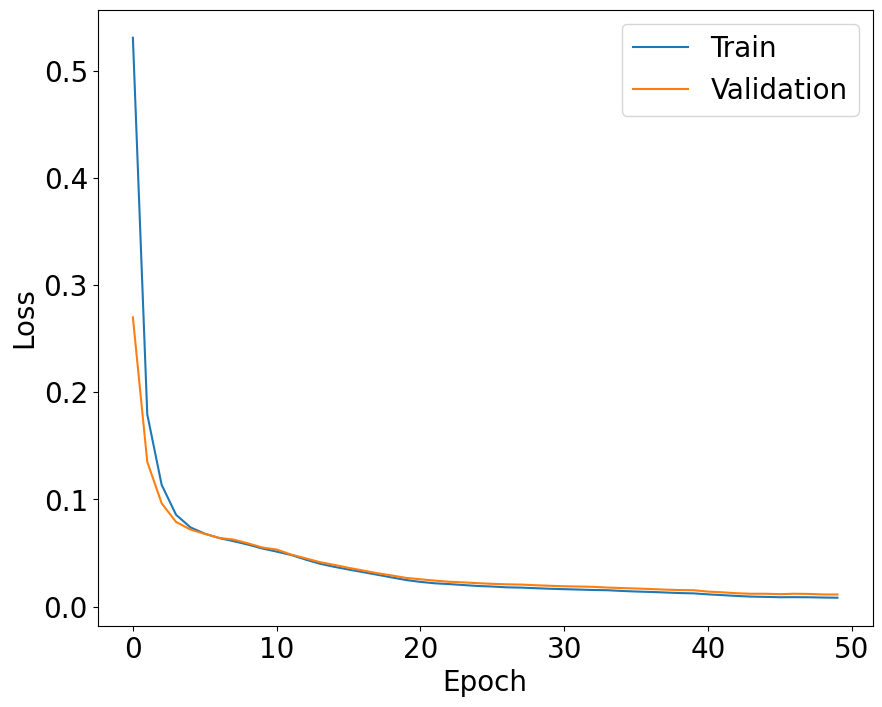

In [16]:
# summarize history for loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.tick_params(axis='both',labelsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=20)
plt.show()

In [9]:
########## saving the autoencoder model
from keras.models import load_model, save_model
autoencoder_model.save("autoencoder_30e.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
### FEATURE EXTRACTION
from keras import models    
model = autoencoder_model
#model = models.load_model('autoencoder_30e.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 10010, 1)]    0         
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 10010, 32)     1600      
                                                                 
 activation_6 (Activation)   (None, 30, 10010, 32)     0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 1430, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 1430, 64)      51264     
                                                                 
 activation_7 (Activation)   (None, 10, 1430, 64)      0         
                                                           

In [11]:
from keras.models import Model
layer_name = 'dense_2'  
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [12]:
features = intermediate_layer_model.predict(train)

157/157 [==============================] - 3s 17ms/step


In [13]:
features.shape

(5005, 13)

In [15]:
np.save('auto30e_features.npy', features)

In [14]:
# convert array into dataframe
df = pd.DataFrame(features)
 
# save the dataframe as a csv file
df.to_csv("X_30e.csv")

In [15]:
# Step 2: Group the DataFrame by the labels in the first column
groups = df.groupby(df.columns[0])

In [16]:
# Step 3: Compute mean and standard deviation for each group
means = groups.mean()
stds = groups.std()

# Combine mean and standard deviation values for all columns
combined_means = means.mean(axis=1)
combined_stds = stds.mean(axis=1)

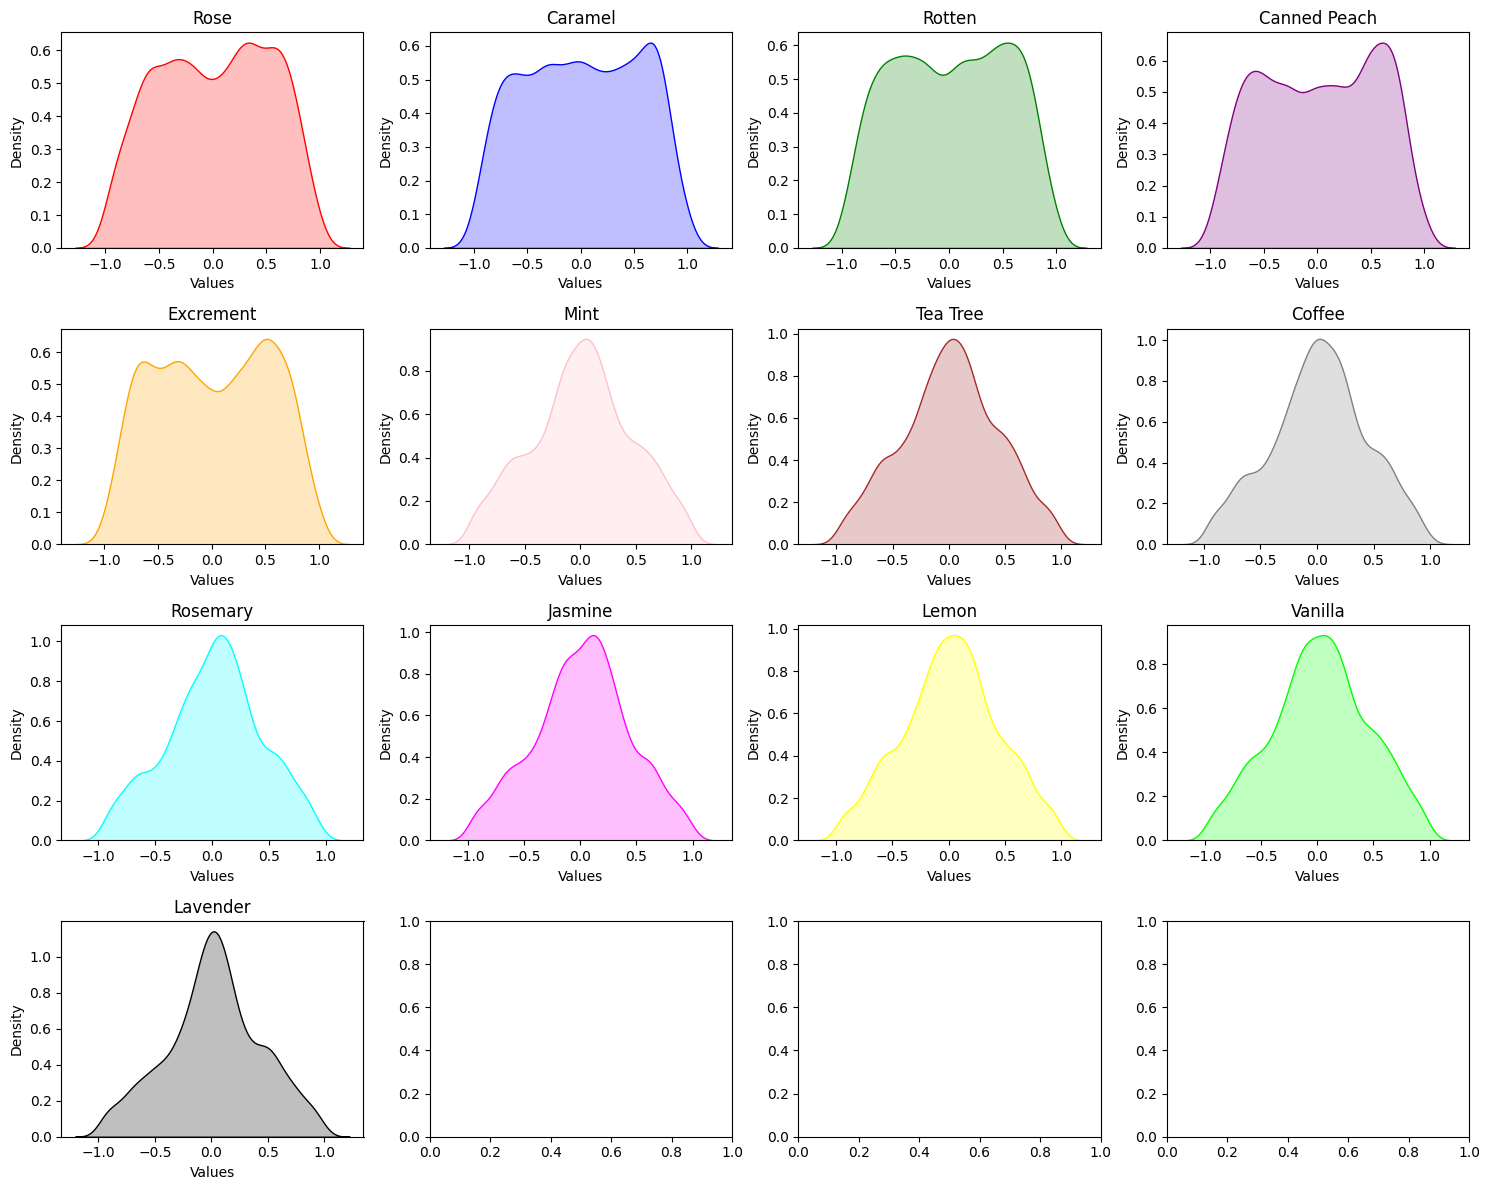

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('X_30e.csv')
groups = df.groupby(df.columns[0])
# Compute mean and standard deviation for each group
means = groups.mean()
stds = groups.std()

# Combine mean and standard deviation values for all columns
combined_means = means.mean(axis=1)
combined_stds = stds.mean(axis=1)

# Dictionary to map label numbers to their corresponding names
legend_names = {'0': 'Rose', '1': 'Caramel', '2': 'Rotten', '3': 'Canned Peach', '4': 'Excrement', '5': 'Mint',
                '6': 'Tea Tree', '7': 'Coffee', '8': 'Rosemary', '9': 'Jasmine', '10': 'Lemon', '11': 'Vanilla',
                '12': 'Lavender'}

# List of manual colors
manual_colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan', 'magenta', 'yellow',
                 'lime', 'black']


# Group the DataFrame by the labels in the first column
groups = df.groupby(df.columns[0])

# Determine number of rows and columns for subplots
num_labels = len(groups)
num_cols = 4  # Number of columns in each row
num_rows = -(-num_labels // num_cols)  # Round up to the nearest integer division

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))
axes = axes.flatten() 

# Plot KDE plot for each label separately
for i, (label, group) in enumerate(groups):
    combined_values = group.iloc[:, 1:].values.flatten()  # Combine all values for the group
    sns.kdeplot(combined_values, fill=True, ax=axes[i], color=manual_colors[int(label)])  # Plot KDE for the combined values

    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Density')
    axes[i].set_title(legend_names[str(label)])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

MATRIX FACTORISATION

In [2]:
# Singular-value decomposition
import numpy as np
from numpy import array
from numpy import diag
from numpy import zeros
from scipy.linalg import svd

X = np.load("auto30e_features.npy")
print("X: ",X.shape)
print(X)
# Select 13 rows after every 35th row to see the data for each odor
A = X[::35][:13]
print(A.shape)

X:  (5005, 13)
[[ 0.01530398 -0.7151403  -0.70084393 ...  0.5565837   0.49430576
   0.3397515 ]
 [-0.6930128   0.4844614  -0.07366225 ... -0.46700132 -0.4712889
  -0.4785163 ]
 [ 0.06309193  0.65962476  0.7404826  ... -0.44136298 -0.5119265
  -0.30098957]
 ...
 [ 0.9825327  -0.8046488   0.24650262 ...  0.31868953  0.9716855
   0.9593979 ]
 [-0.91564846  0.92935055  0.4905875  ... -0.8749423  -0.54550636
  -0.93854517]
 [ 0.9130392  -0.9493713  -0.9142228  ...  0.32907683  0.9626234
   0.9472787 ]]


In [2]:
import pandas as pd
import numpy as np
# features file was converted from npy to csv
# Read the CSV file into a DataFrame
df = pd.read_csv('X_30e.csv')

# Grouping by the first column
groups = df.groupby(df.columns[0])

legend_names = {'0': 'Rose', '1': 'Caramel', '2': 'Rotten', '3': 'Canned Peach', '4': 'Excrement', '5': 'Mint',
                '6': 'Tea Tree', '7': 'Coffee', '8': 'Rosemary', '9': 'Jasmine', '10': 'Lemon', '11': 'Vanilla',
                '12': 'Lavender'}


# Function to perform SVD and print the output matrices
def svd_and_print(group):
    # Extract the data for the SVD
    data = group.iloc[:, 1:].values  
    print(data.shape)
    # Perform SVD
    U, s, Vt = np.linalg.svd(data, full_matrices=False)

    # Output matrices
    group_name = legend_names[str(group.iloc[:, 0].iloc[0])] 
    print("Group:", group_name)

    print("U Matrix: ", U.shape)
    print(U)
    print("Singular Values: ", np.diag(s).shape)
    print(np.diag(s))
    print("V^T Matrix: ", Vt.shape)
    print(Vt)
    print()

# Apply the function to each group
for name, group in groups:
    svd_and_print(group)

(385, 13)
Group: Rose
U Matrix:  (385, 13)
[[-0.05445771 -0.01111571 -0.0481214  ...  0.00821573 -0.00605906
   0.03894435]
 [ 0.04849498 -0.04827324  0.02683729 ... -0.00302617  0.01790258
  -0.02572557]
 [ 0.06369996  0.02567346  0.02904939 ...  0.01365412  0.03668408
   0.01520104]
 ...
 [ 0.01353965  0.04216692 -0.04278245 ... -0.02781557  0.03797663
   0.02233843]
 [ 0.03792871  0.01757234 -0.01790617 ... -0.00070393 -0.06875661
  -0.04514422]
 [-0.02871281 -0.00648988 -0.08083269 ... -0.01040055  0.02829446
   0.03710154]]
Singular Values:  (13, 13)
[[22.54794143  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.         17.56796533  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.         14.79448037  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.       